In [5]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

Init Plugin
Init Graph Optimizer
Init Kernel


In [6]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/virginia_opossum
oregon_wildlife/raccoon
oregon_wildlife/red_fox
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/raven
oregon_wildlife/nutria
oregon_wildlife/sea_lions
oregon_wildlife/deer
oregon_wildlife/cougar

total img num: 7168


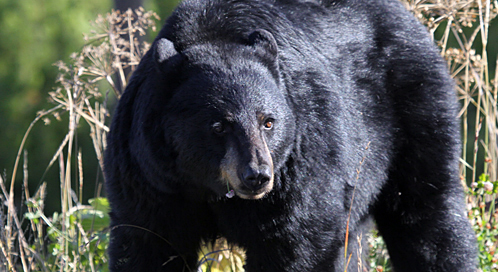

black_bear


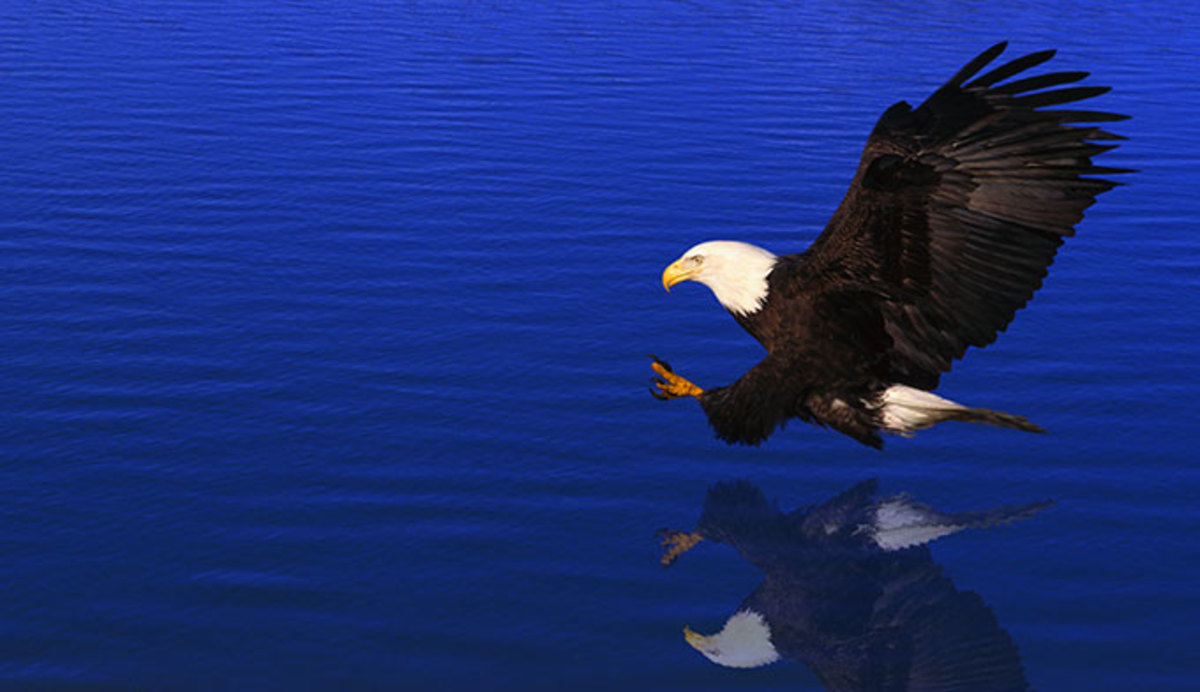

bald_eagle


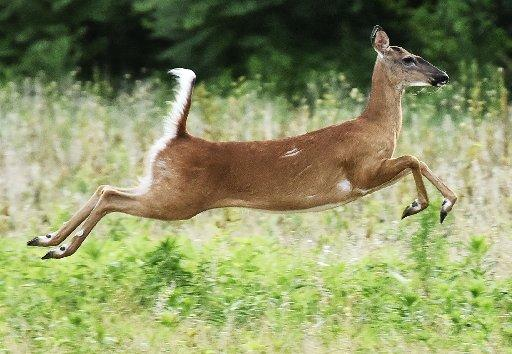

deer


In [7]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [8]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [9]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [10]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 6, 7, 6, 9, 7, 5, 9, 5, 9]


In [11]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [12]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('val.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_val, label_val):
        writer.writerow([img_path, label])

In [13]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

In [15]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )


    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        
        rows = pd.read_csv(filename.decode("utf-8"))
        img_paths = rows['img_path'].tolist()
        labels = rows['label'].tolist()
        
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = load_image(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [16]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

def dataset_generator_fun_train(*args):
    filename = 'train.csv'
    return TimeMeasuredDataset(filename)

def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_val).batch(BATCH_SIZE)

Metal device set to: Apple M1 Pro


tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[2.10486914e+04 9.58758406e-03]
 [2.10487012e+04 1.10268414e-01]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


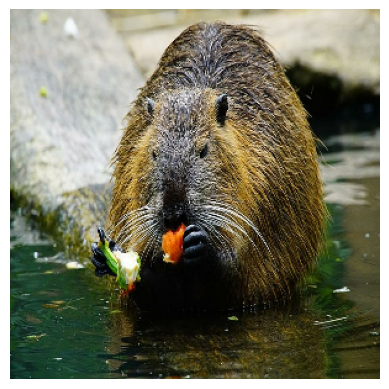

nutria


In [17]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [18]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [19]:
wild_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [20]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [22]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def val_step(images, labels):
    predictions = wild_model(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [23]:
def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 3

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.ceil(len(img_path_train)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):        
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        print("validating:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.ceil(len(img_path_val)/BATCH_SIZE)):
            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            val_enter = time.perf_counter()
            val_step(images, labels)
            val_elapsed = time.perf_counter() - val_enter

            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, [["Val"]]), axis=0)
                times_acc = tf.concat((times_acc, [(val_enter, val_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, val Loss: {:.4f}, val Accuracy: {:.4f}'
        print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [24]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [58]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_val)

training:


100%|███████████████████████████████████████| 5734/5734 [16:09<00:00,  5.91it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [03:51<00:00,  6.19it/s]


Epoch 1, Loss: 2.3813, Accuracy: 26.4039, val Loss: 2.2539, val Accuracy: 22.5244
training:


100%|███████████████████████████████████████| 5734/5734 [30:42<00:00,  3.11it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [06:44<00:00,  3.55it/s]


Epoch 2, Loss: 1.4020, Accuracy: 45.2040, val Loss: 1.7941, val Accuracy: 30.4742
training:


100%|███████████████████████████████████████| 5734/5734 [42:41<00:00,  2.24it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [10:20<00:00,  2.31it/s]


Epoch 3, Loss: 1.1550, Accuracy: 56.2783, val Loss: 2.2335, val Accuracy: 23.1520
Execution time: 6630.513423625


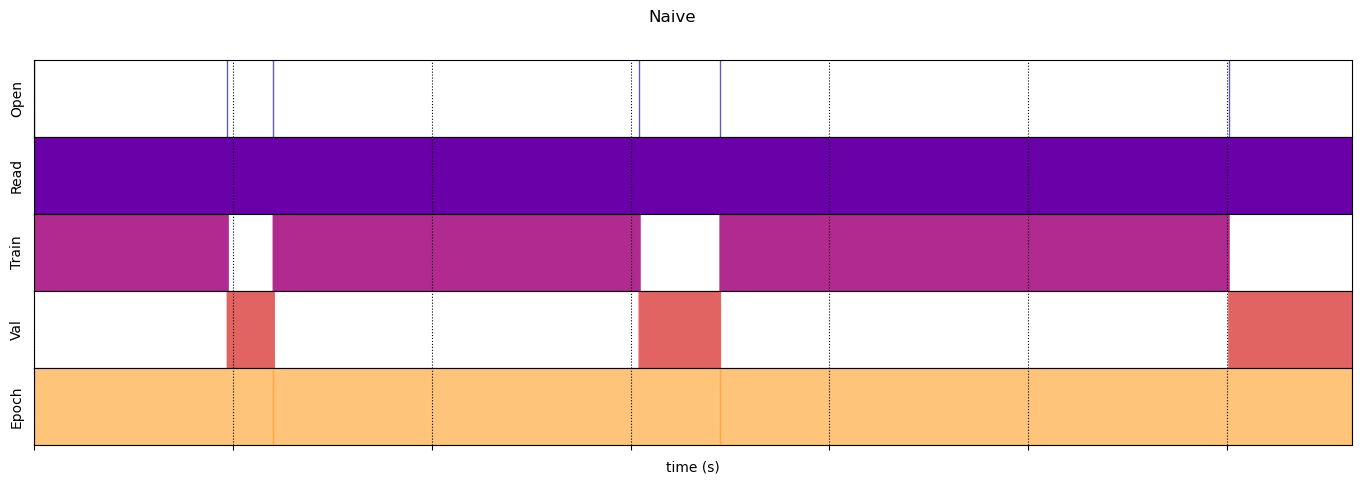

In [59]:
draw_timeline(timeline_Naive, "Naive", 500)

### Use Data Augmentation

In [25]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

def dataset_generator_fun_train(*args):
    filename = 'train.csv'
    return TimeMeasuredDataset(filename)

def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')

In [26]:
# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_HEIGHT,IMAGE_WIDTH,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

# parse testing data
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_HEIGHT,IMAGE_WIDTH,3])
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [27]:
dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun)
    
dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_val)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_test)

In [28]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation)

training:


100%|███████████████████████████████████████| 5734/5734 [17:01<00:00,  5.62it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [37:09<00:00,  1.55s/it]


Epoch 1, Loss: 2.5558, Accuracy: 10.0977, val Loss: 2.4425, val Accuracy: 10.5300
training:


100%|█████████████████████████████████████| 5734/5734 [3:29:40<00:00,  2.19s/it]


validating:


100%|███████████████████████████████████████| 1434/1434 [06:39<00:00,  3.59it/s]


Epoch 2, Loss: 2.3174, Accuracy: 10.5860, val Loss: 2.5152, val Accuracy: 8.5077
training:


100%|███████████████████████████████████████| 5734/5734 [44:04<00:00,  2.17it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [10:34<00:00,  2.26it/s]


Epoch 3, Loss: 2.3063, Accuracy: 10.0105, val Loss: 2.4871, val Accuracy: 9.8326
Execution time: 6841.438766166


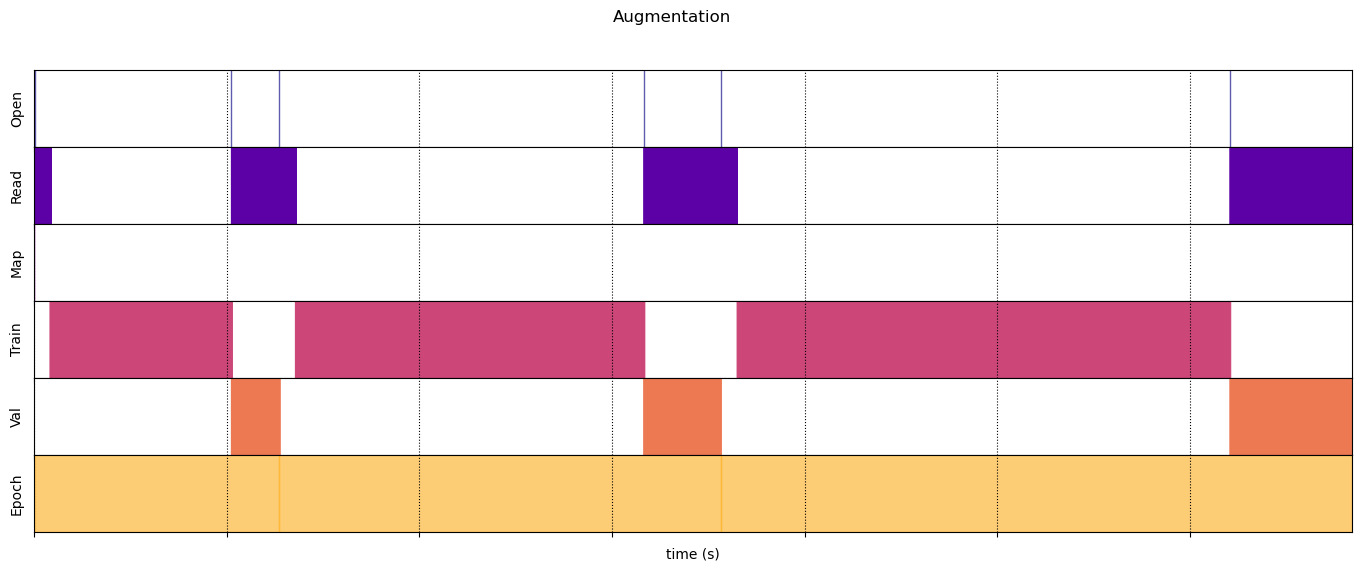

In [29]:
draw_timeline(timeline_Augmentation, "Augmentation", 500)

Comparing the method used in augmentation and naive, it can be clearly seen that the time consumed in augmentation is way more. Naive would only take around 20-40 mins each epoch while augmentation would take hours to complete each epoch. One of the main reason first would be that since I am using an M1 Macbook Pro hence there is a bug with tensorflow which doesn't allow me to use my laptop's GPU, moreover the big difference in time is mainly caused by our map function, since that it would take more time for the model to train and also apply our map function.

Accuracy-wise it is a little bit weird why it is actually lower than the naive method, one of the reasons might be that there are some things that should be reconfigure in the map function, but due to long training time I can only try it a couple of times and I've tried to remove the cropping part but it still results in the same accuracy value, I've also tried changing the hyperparameters like batch size and buffer size, but it also results in the same accuracy value. Another thing that I've tried is to change the parameters used for random brightness and random contrast, but it all still results in the same accuracy value.

### Use Data Augmentation + Optimization

In [30]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

def dataset_generator_fun_train(*args):
    filename = 'train.csv'
    return TimeMeasuredDataset(filename)

def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')

In [31]:
# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_HEIGHT,IMAGE_WIDTH,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

# parse testing data
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_HEIGHT,IMAGE_WIDTH,3])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [33]:
dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)

dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [34]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized)

training:


100%|███████████████████████████████████████| 5734/5734 [12:29<00:00,  7.65it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [00:49<00:00, 28.98it/s]


Epoch 1, Loss: 3.3210, Accuracy: 10.7255, val Loss: 4.5674, val Accuracy: 10.6695
training:


100%|███████████████████████████████████████| 5734/5734 [11:08<00:00,  8.58it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [00:50<00:00, 28.38it/s]


Epoch 2, Loss: 2.3034, Accuracy: 10.2197, val Loss: 3.9213, val Accuracy: 10.5997
training:


100%|███████████████████████████████████████| 5734/5734 [11:22<00:00,  8.40it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [00:49<00:00, 29.25it/s]


Epoch 3, Loss: 2.3024, Accuracy: 10.5685, val Loss: 3.9218, val Accuracy: 10.5997
Execution time: 2249.640279542


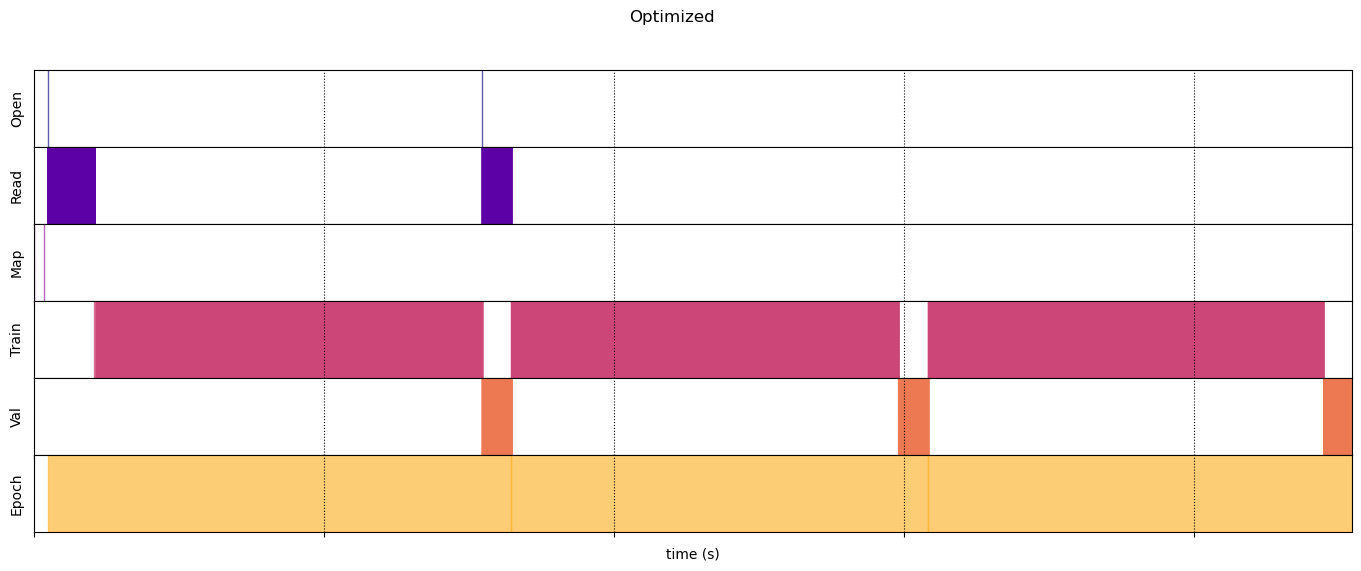

In [35]:
draw_timeline(timeline_Optimized, "Optimized", 500)

Comparing the optimized method with the augmetation method, we can also clearly see that running the optimized method will run the fastest as it only take around 10 mins per epoch. Moreover we can also see that it has a sliglthy higher accuracy but still not as high as the naive method, which might also be caused by some miss configuration in the map function. But this is all still expected because we can see that after doing some optimization we can get a much lower runtime each epoch.